Dimensionality Reduction Comparison
---
#### Method Testing
##### May 2019


Using discrete (`inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz`, Mocosko, _et al_ 2015) and continuous (`inputs/qi_s1_edited_all.csv.gz`) datasets, downsample and feature select, then perform various DR techniques and compare the following:
* __Euclidean cell-cell distance__ correlations before and after transformation/reduction
* __Kullback-Leibler Divergence (KLD)__ explaining the Shannon entropy of the difference between the cumulative probability distributions of unique, normalized cell-cell distances.
* __K-nearest neighbor (Knn)__ preservation

In [8]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

In [190]:
from scvi.dataset import CsvDataset, GeneExpressionDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
use_batches=False
use_cuda=True

---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ 
* _cluster_ and _downsample proportionally_ for future processing

In [19]:
P14Retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

In [20]:
P14Retina.data.shape

(6600, 20478)

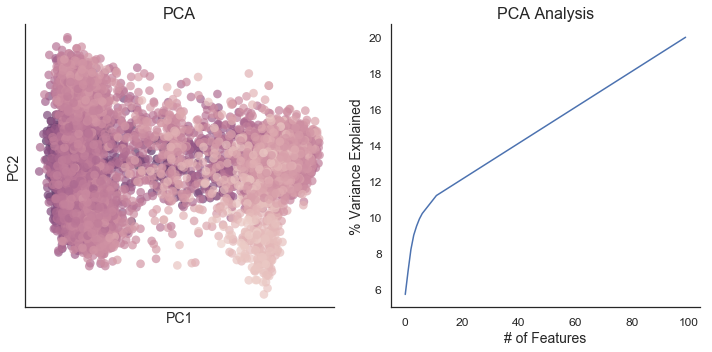

In [21]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(norm='l1'), n_components=100)
P14Retina_PCA100.plot_PCA()

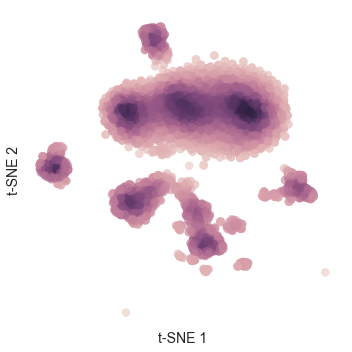

CPU times: user 1min 5s, sys: 1.24 s, total: 1min 7s
Wall time: 1min 7s


In [22]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30, seed=11) 
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12e481518>)

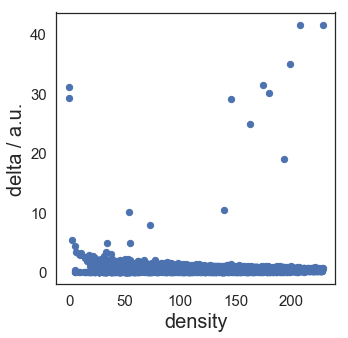

In [23]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x154423ba8>)

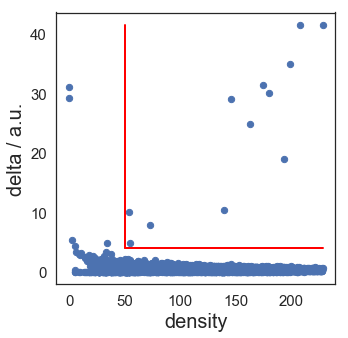

In [26]:
P14Retina_tSNE.clu.assign(50,4) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

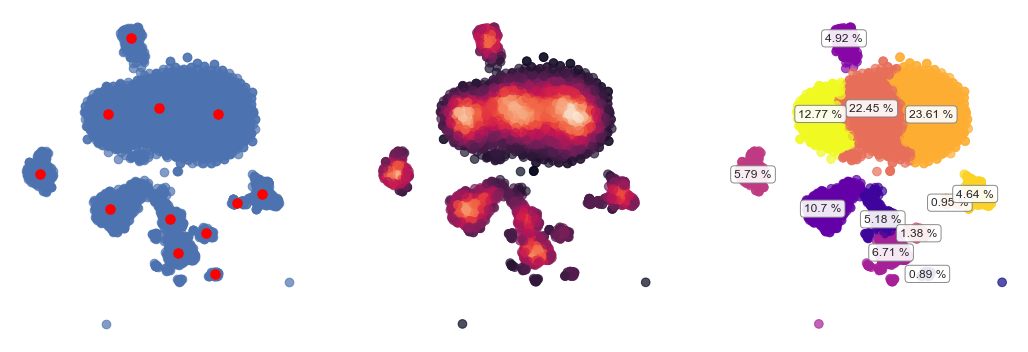

In [27]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [28]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.5002935528755188



In [29]:
P14Retina_tSNE.clu.membership.tofile('../inputs/P14Retina_clusters.csv',sep=',',format='%10.5f') # write clustering to file to use with SIMLR

---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_
* _ZIFA_
* _scVI_

In [156]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [157]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

In [158]:
# save downsampled results to file for scVI testing
P14Retina_0.data.to_csv('../inputs/GSM1626793_P14Retina_1_1kcells.csv')

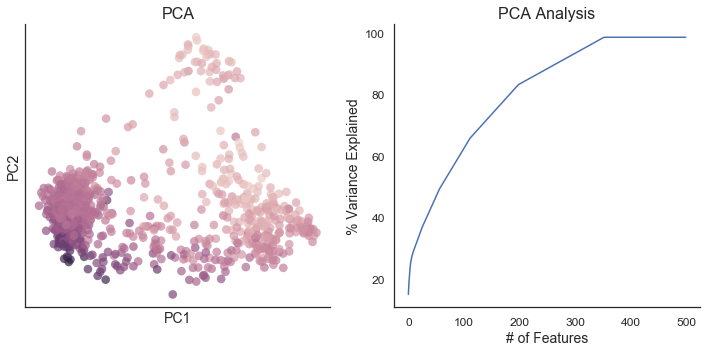

In [159]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot_PCA()

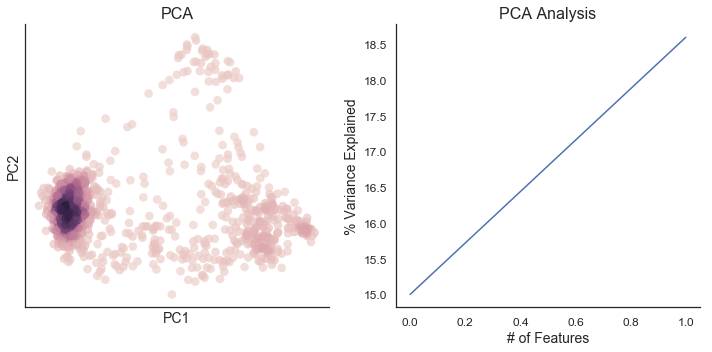

In [160]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot_PCA()

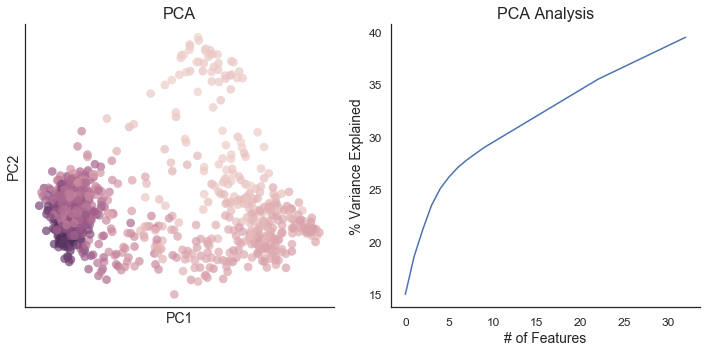

In [161]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot_PCA()

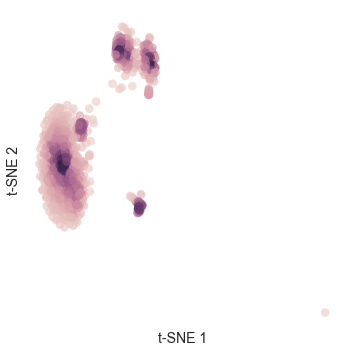

In [165]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

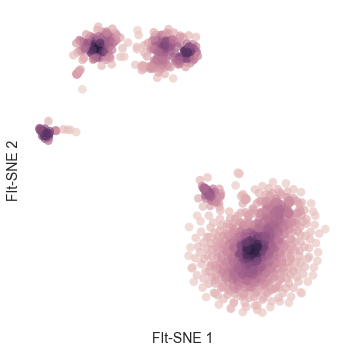

In [163]:
P14Retina_0_FItSNE = fcc_FItSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # t-SNE with perplexity 30
P14Retina_0_FItSNE.plot()

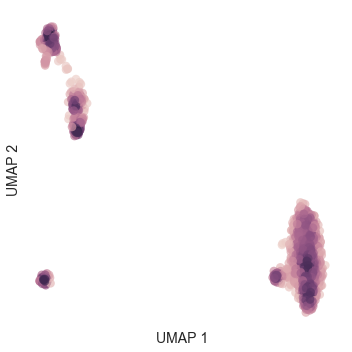

In [164]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [166]:
%time P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts of 500 selected features

DCA: Successfully preprocessed 499 genes and 1006 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 22 s, sys: 3.34 s, total: 25.3 s
Wall time: 15 s


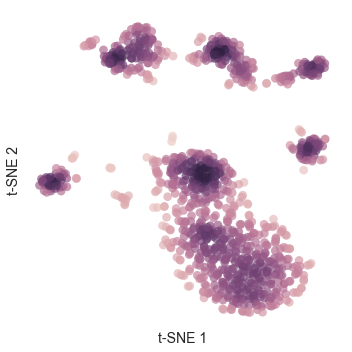

In [167]:
dca = RNA_counts(data=P14Retina_0_DCA.results)
P14Retina_0_DCAtSNE = fcc_tSNE(dca.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # t-SNE with perplexity 30 to visualize DCA
P14Retina_0_DCAtSNE.plot()

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1006, D = 480, K = 2, n_blocks = 1
Block sizes [480]
Param change below threshold 1.000e-02 after 12 iterations


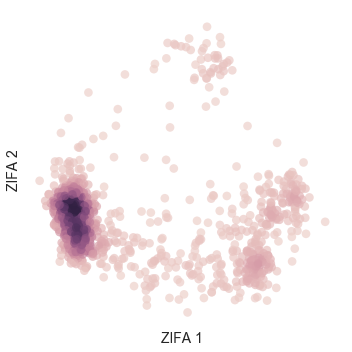

CPU times: user 2min 38s, sys: 24.6 s, total: 3min 2s
Wall time: 1min 34s


In [168]:
%%time
P14Retina_0_ZIFA = fcc_ZIFA(P14Retina_0.arcsinh_norm(norm='l1'), K=2)
P14Retina_0_ZIFA.plot()

In [171]:
# Loading a local dataset into scVI
P14Retina_scVI = CsvDataset('GSM1626793_P14Retina_1_1kcells.csv.gz', save_path='../inputs/', compression='gzip', new_n_genes=500, gene_by_cell=False) 

File ../inputs/GSM1626793_P14Retina_1_1kcells.csv.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [172]:
vae = VAE(P14Retina_scVI.nb_genes, n_batch=P14Retina_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              P14Retina_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [01:15<00:00,  4.97it/s]


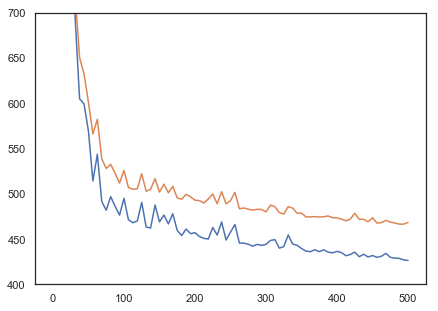

In [179]:
%matplotlib inline
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.figure(figsize=(7,5))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(400,700)
plt.show()

In [174]:
full = trainer.create_posterior(trainer.model, P14Retina_scVI, indices=np.arange(len(P14Retina_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

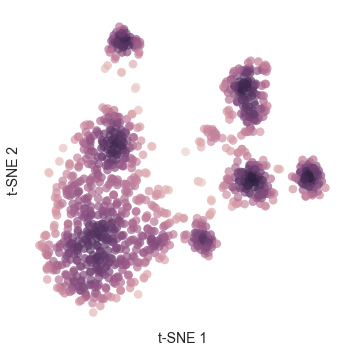

In [175]:
P14Retina_scVI_tSNE = fcc_tSNE(matrix=latent, perplexity=30, seed=18)
P14Retina_scVI_tSNE.plot()

In [176]:
P14Retina_scVI_results = DR(matrix=latent)
P14Retina_scVI_results.results = latent
P14Retina_scVI_results.clu = Cluster(latent.astype('double'), autoplot=False)
P14Retina_scVI_results.name = 'scVI'

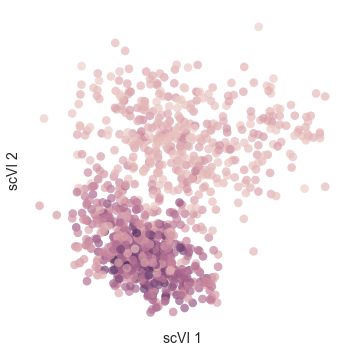

In [177]:
P14Retina_scVI_results.plot()

---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [213]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [180]:
k = 30 # choose value for K-nearest neighbor calculations

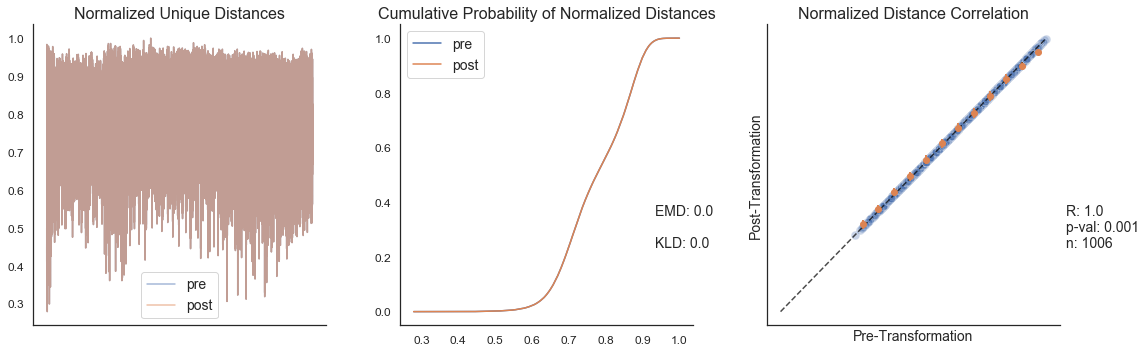

Knn Preservation: 100.0

CPU times: user 30.7 s, sys: 4.44 s, total: 35.1 s
Wall time: 34.3 s


In [182]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

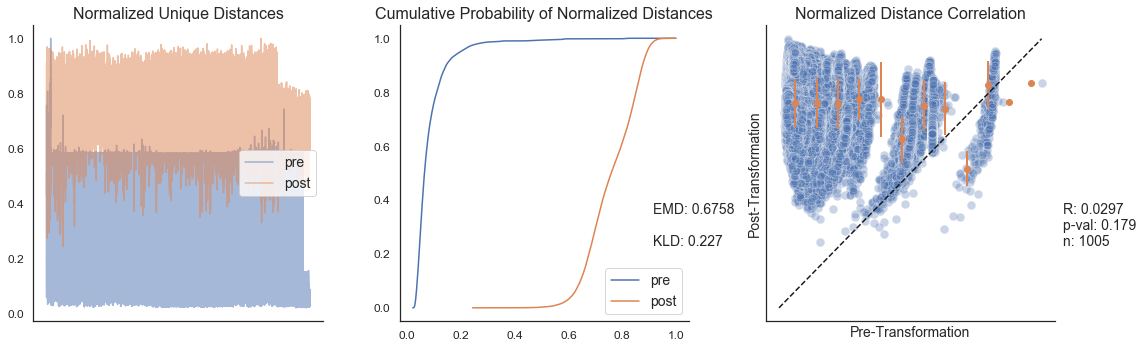

Knn Preservation: 95.6536

CPU times: user 33.1 s, sys: 4.41 s, total: 37.6 s
Wall time: 37.4 s


In [35]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000))))

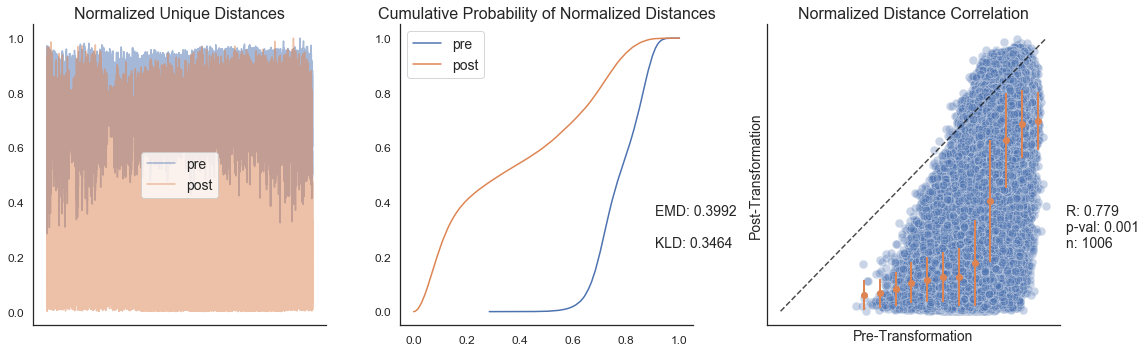

Knn Preservation: 95.9245

CPU times: user 29.2 s, sys: 3.62 s, total: 32.8 s
Wall time: 32.3 s


In [54]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

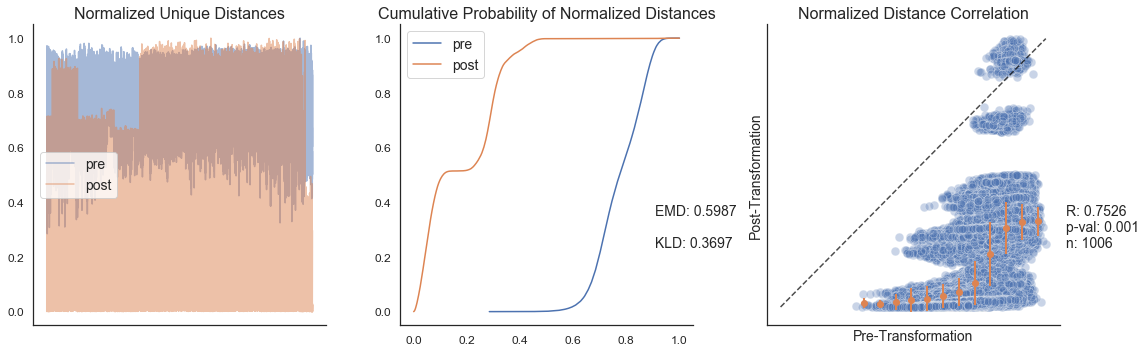

Knn Preservation: 95.6507

CPU times: user 28.8 s, sys: 3.61 s, total: 32.4 s
Wall time: 31.8 s


In [55]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

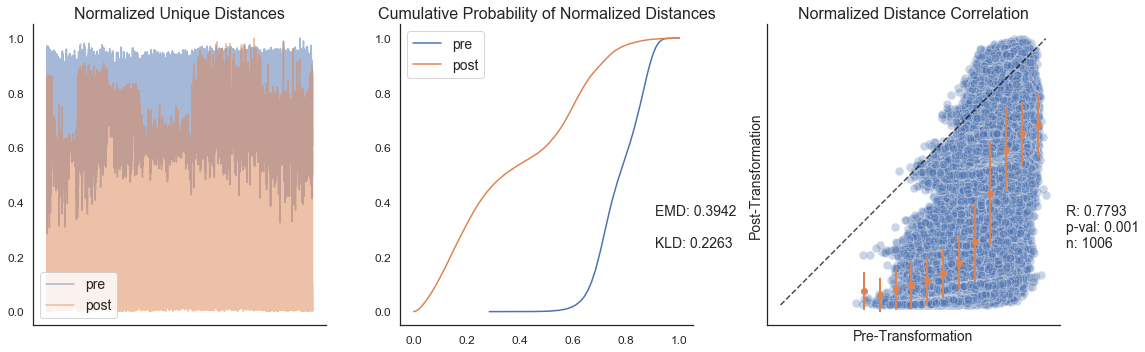

Knn Preservation: 95.7197

CPU times: user 29.4 s, sys: 3.01 s, total: 32.4 s
Wall time: 31.9 s


In [56]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_FItSNE.knn_graph(k))))

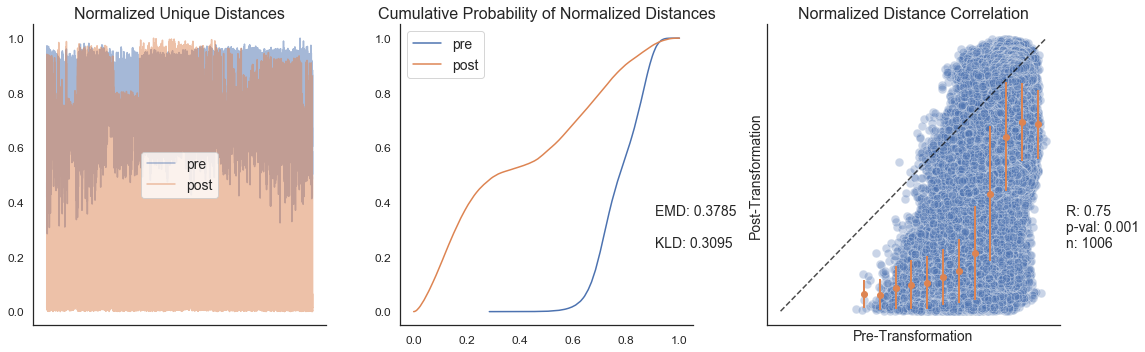

Knn Preservation: 95.3116

CPU times: user 29.1 s, sys: 3.49 s, total: 32.6 s
Wall time: 32 s


In [57]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

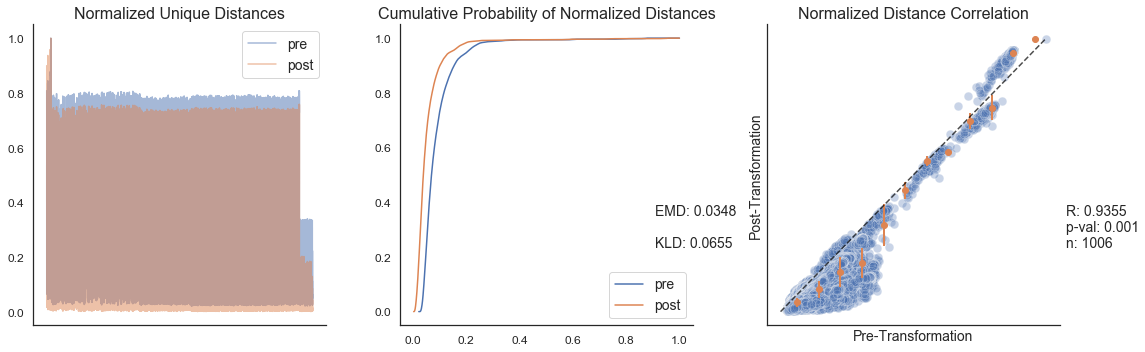

Knn Preservation: 96.1432

CPU times: user 29.6 s, sys: 4.03 s, total: 33.7 s
Wall time: 33.1 s


In [58]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

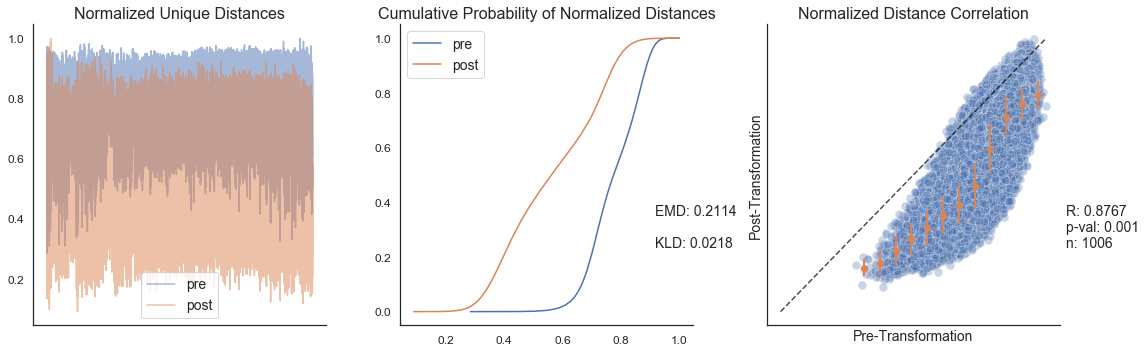

Knn Preservation: 96.8683

CPU times: user 30.1 s, sys: 4.28 s, total: 34.4 s
Wall time: 33.8 s


In [59]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))

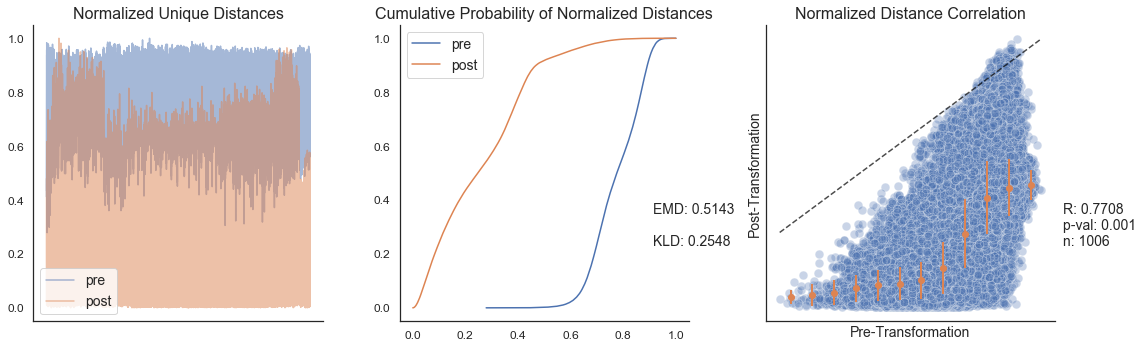

Knn Preservation: 95.5197

CPU times: user 28.9 s, sys: 3.99 s, total: 32.9 s
Wall time: 32.3 s


In [215]:
%%time
# look at ZIFA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_ZIFA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_ZIFA.knn_graph(k))))

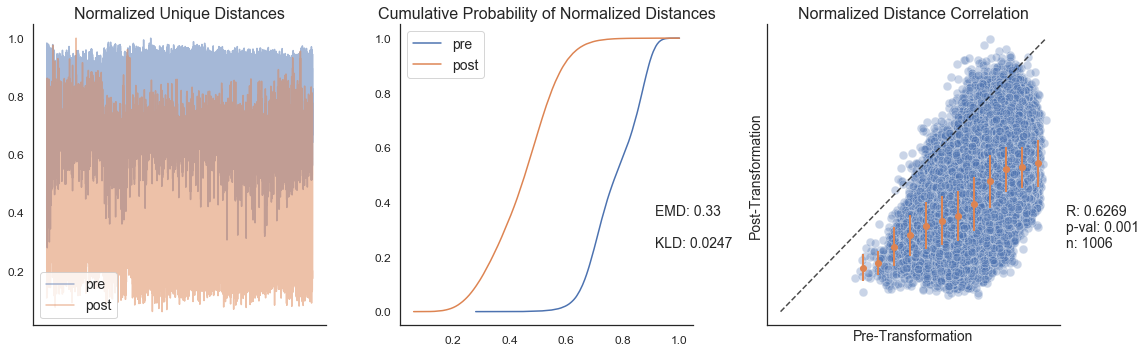

Knn Preservation: 95.516

CPU times: user 30.2 s, sys: 4 s, total: 34.2 s
Wall time: 33.6 s


In [183]:
%%time
# look at scVI vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_scVI_results.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_scVI_results.knn_graph(k))))

---
#### 3. repeat for continuous dataset

---
#### 3.0. read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [9]:
%time qi = RNA_counts.from_file('../inputs/qi_s1_edited_all.csv.gz', cells_axis=0, labels=[None,None])

CPU times: user 15.1 s, sys: 828 ms, total: 15.9 s
Wall time: 16.1 s


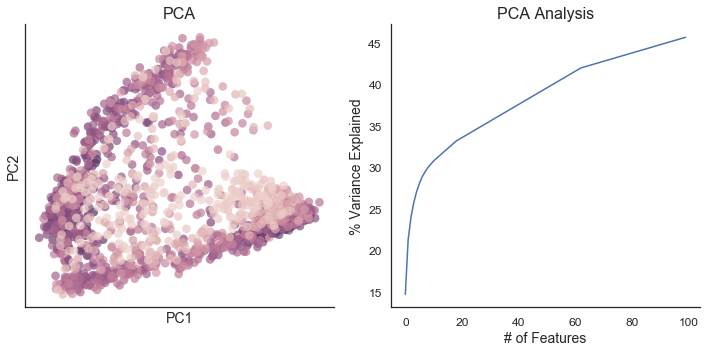

In [10]:
qi_PCA100 = fcc_PCA(qi.arcsinh_norm(), n_components=100)
qi_PCA100.plot_PCA()

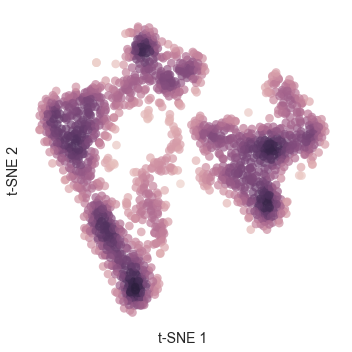

In [11]:
qi_tSNE = fcc_tSNE(qi_PCA100.results, perplexity=30, seed=18)
qi_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12e70f7b8>)

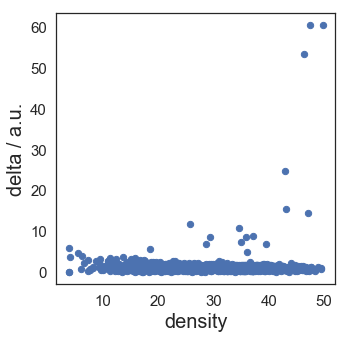

In [12]:
qi_tSNE.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ebfef60>)

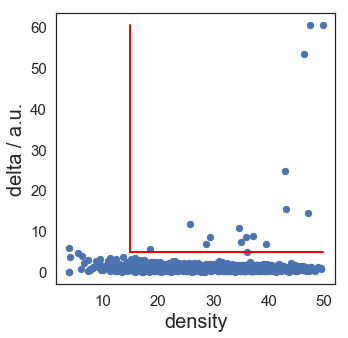

In [15]:
qi_tSNE.clu.assign(min_delta=5, min_density=15)
qi_tSNE.clu.draw_decision_graph(min_delta=qi_tSNE.clu.min_delta, min_density=qi_tSNE.clu.min_density)

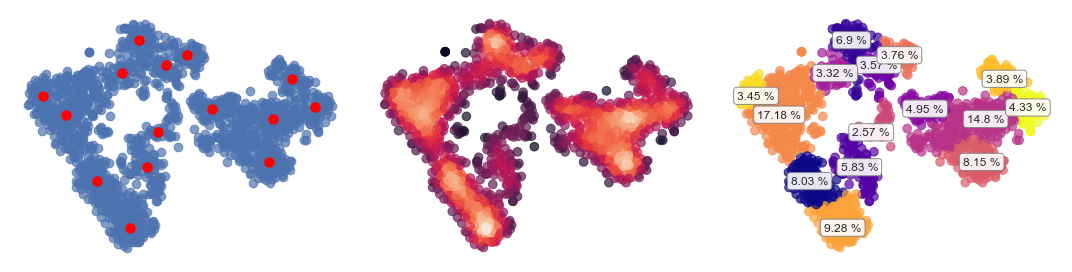

In [16]:
qi_tSNE.plot_clusters()

In [18]:
qi_tSNE.clu.membership.tofile('qi_clusters.csv',sep=',',format='%10.5f') # write clustering to file to use with SIMLR

---
#### 3.1. feature-select continuous dataset and perform DRs
* select _600 most variable genes_
* _600-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_
* _ZIFA_
* _scVI_

In [4]:
# select 500 most variable genes
qi_0 = RNA_counts.var_select(qi, n_features=500) 

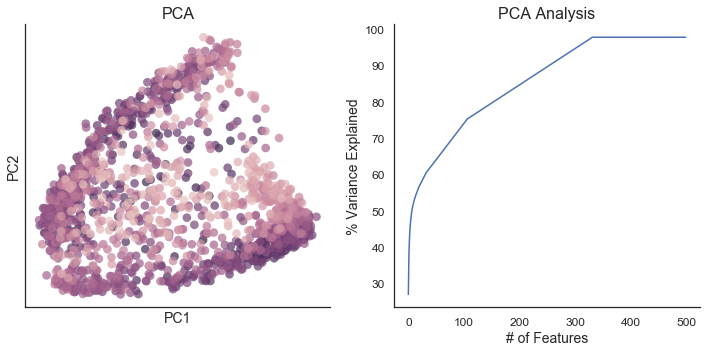

In [185]:
qi_0_PCA500 = fcc_PCA(qi_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
qi_0_PCA500.plot_PCA()

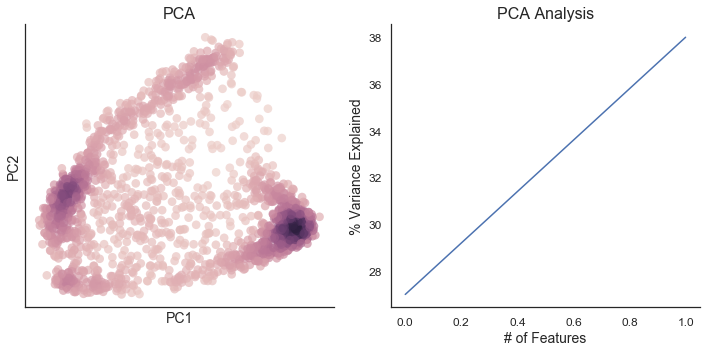

In [186]:
qi_0_PCA2 = fcc_PCA(qi_0.arcsinh_norm(), n_components=2) # 2 component PCA
qi_0_PCA2.plot_PCA()

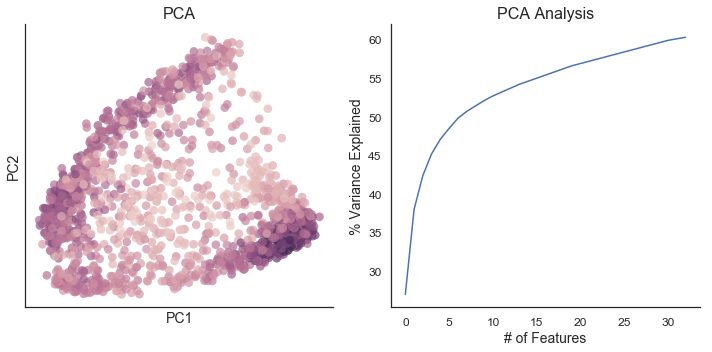

In [187]:
qi_0_PCA33 = fcc_PCA(qi_0.arcsinh_norm(), n_components=33) # 33 component PCA to compare to DCA
qi_0_PCA33.plot_PCA()

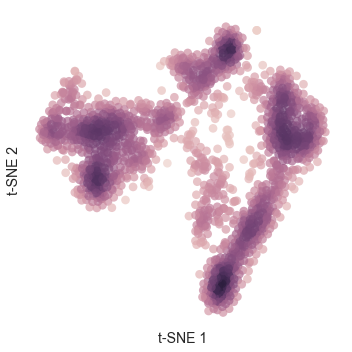

In [188]:
qi_0_tSNE = fcc_tSNE(qi_0.arcsinh_norm(), perplexity=30, seed=18) # t-SNE with perplexity 30
qi_0_tSNE.plot()

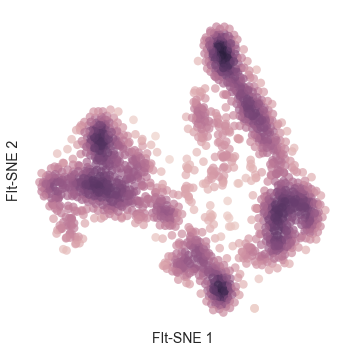

In [115]:
qi_0_FItSNE = fcc_FItSNE(qi_0.arcsinh_norm(), perplexity=30, seed=18) # FIt-SNE with perplexity 30
qi_0_FItSNE.plot()

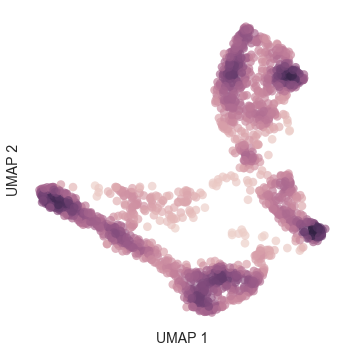

In [116]:
qi_0_UMAP = fcc_UMAP(qi_0.arcsinh_norm(), perplexity=30, seed=18) # UMAP with perplexity 30
qi_0_UMAP.plot()

In [117]:
qi_0_DCA = fcc_DCA(qi_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 600 genes and 1595 cells.
Calculating low dimensional representations...
Calculating reconstructions...


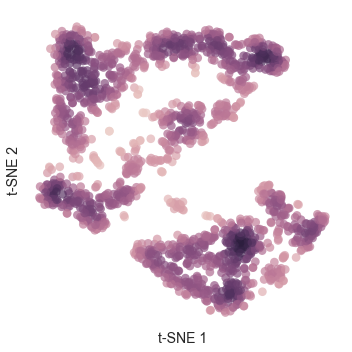

In [118]:
test = RNA_counts(data=qi_0_DCA.results)
qi_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(), perplexity=30, seed=18) # t-SNE with perplexity 30 to visualize DCA
qi_0_DCAtSNE.plot()

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1595, D = 597, K = 2, n_blocks = 1
Block sizes [597]
Param change below threshold 1.000e-02 after 7 iterations


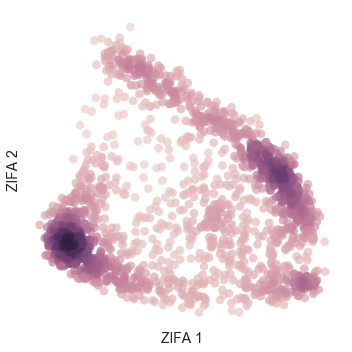

CPU times: user 3min 22s, sys: 37.2 s, total: 3min 59s
Wall time: 2min 10s


In [119]:
%%time
qi_0_ZIFA = fcc_ZIFA(qi_0.arcsinh_norm(), K=2)
qi_0_ZIFA.plot()

In [200]:
# Loading a local dataset into scVI
qi_scVI = CsvDataset('qi_s1_edited_all_wlabels.csv.gz', save_path='../inputs/', compression='gzip', new_n_genes=500, gene_by_cell=False) 

File ../inputs/qi_s1_edited_all_wlabels.csv.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 25507 to 500 genes
Downsampling from 1595 to 1595 cells


In [201]:
vae = VAE(qi_scVI.nb_genes, n_batch=qi_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              qi_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|███████████████████████████████████████████████████████████████████████████████████| 400/400 [02:00<00:00,  3.13it/s]


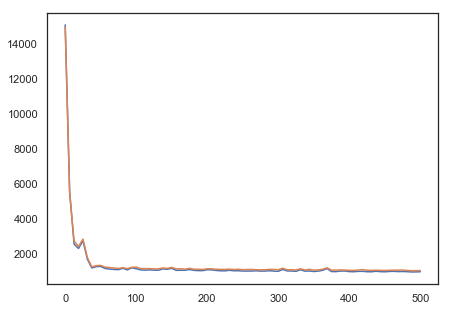

In [202]:
%matplotlib inline
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.figure(figsize=(7,5))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.show()

In [203]:
full = trainer.create_posterior(trainer.model, qi_scVI, indices=np.arange(len(qi_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

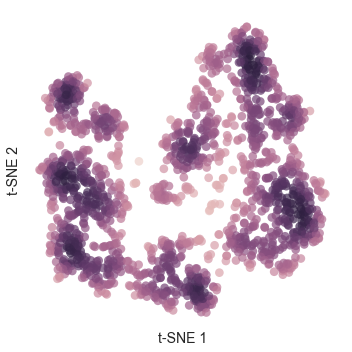

In [204]:
qi_scVI_tSNE = fcc_tSNE(matrix=latent, perplexity=30, seed=18)
qi_scVI_tSNE.plot()

In [205]:
qi_scVI_results = DR(matrix=latent)
qi_scVI_results.results = latent
qi_scVI_results.clu = Cluster(latent.astype('double'), autoplot=False)
qi_scVI_results.name = 'scVI'

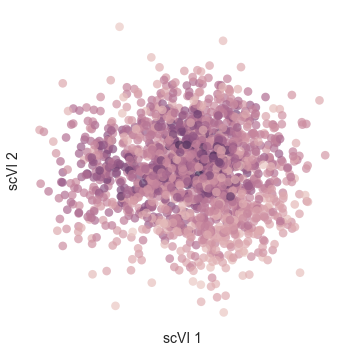

In [206]:
qi_scVI_results.plot()

---
#### 3.2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

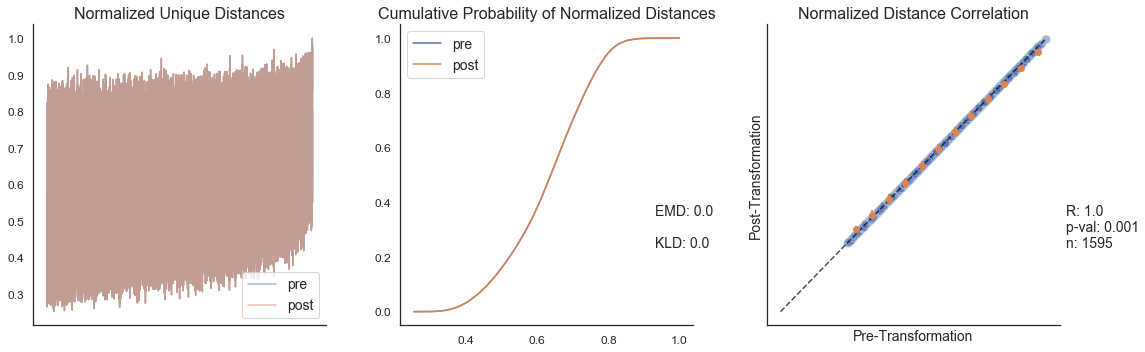

Knn Preservation: 100.0

CPU times: user 1min 36s, sys: 14.9 s, total: 1min 51s
Wall time: 1min 51s


In [128]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA500.knn_graph(k))))

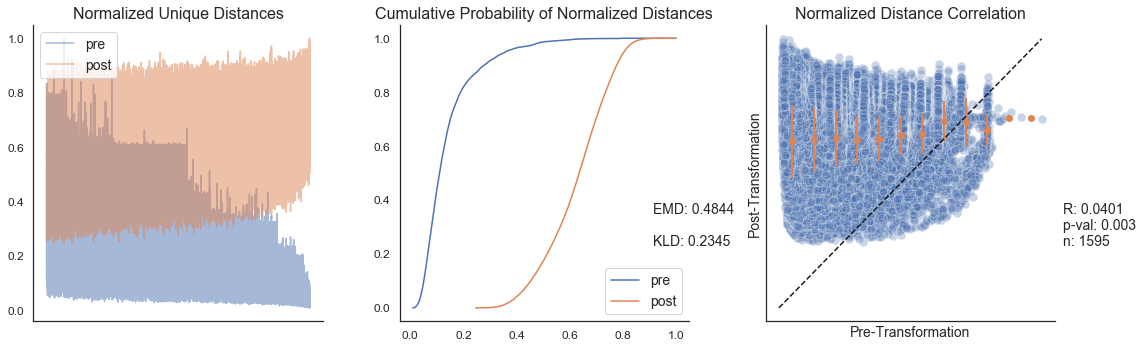

Knn Preservation: 97.1933

CPU times: user 1min 39s, sys: 16.7 s, total: 1min 55s
Wall time: 1min 56s


In [67]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0.knn_graph(k, transform='arcsinh', scale=1000))))

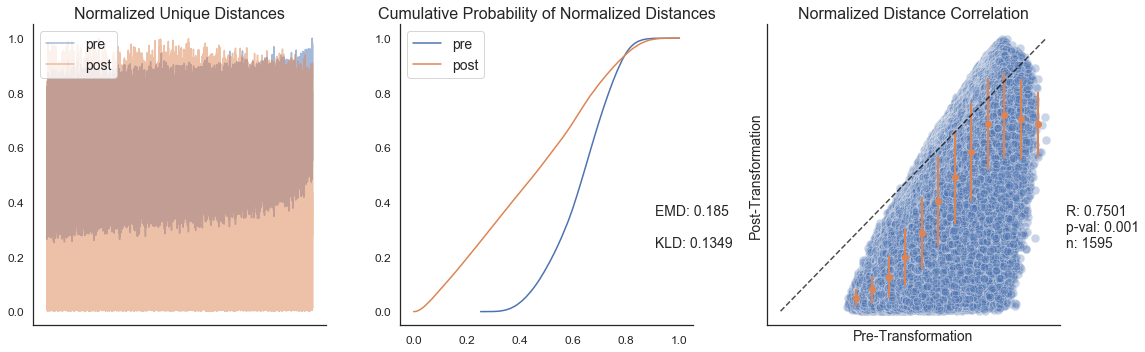

Knn Preservation: 97.7215

CPU times: user 1min 27s, sys: 12.2 s, total: 1min 39s
Wall time: 1min 39s


In [129]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA2.knn_graph(k))))

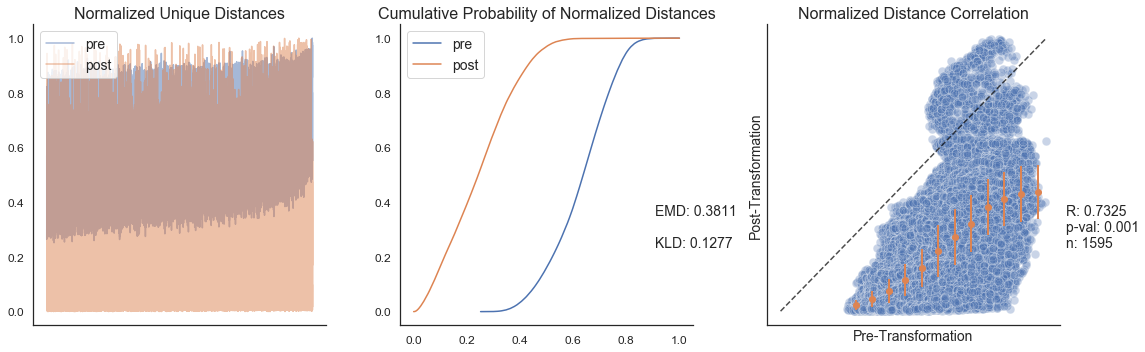

Knn Preservation: 97.5601

CPU times: user 1min 25s, sys: 11.6 s, total: 1min 36s
Wall time: 1min 36s


In [130]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_tSNE.knn_graph(k))))

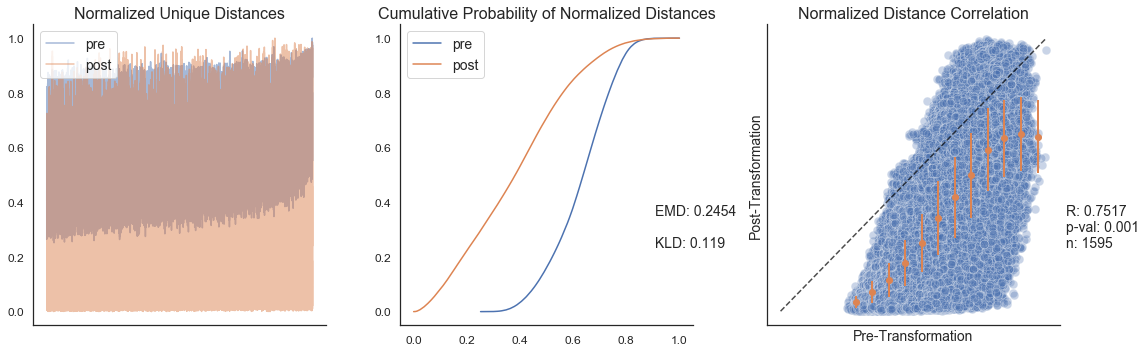

Knn Preservation: 97.5746

CPU times: user 1min 27s, sys: 11.9 s, total: 1min 39s
Wall time: 1min 39s


In [131]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_FItSNE.knn_graph(k))))

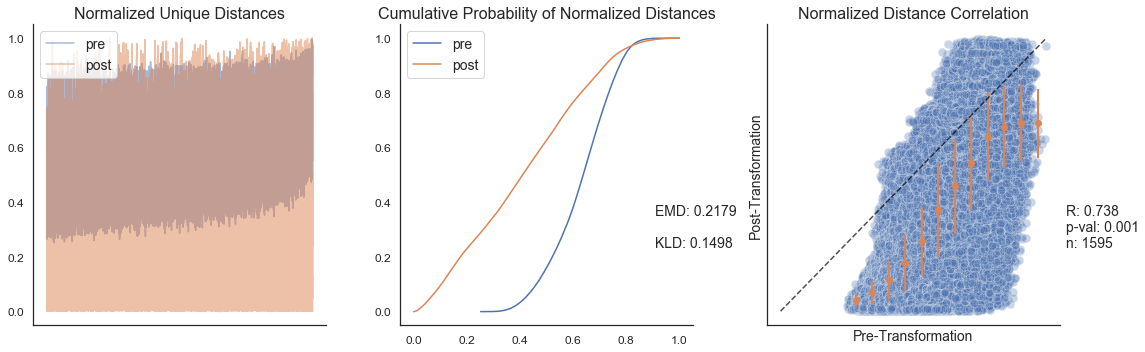

Knn Preservation: 97.4856

CPU times: user 1min 25s, sys: 12.3 s, total: 1min 38s
Wall time: 1min 38s


In [132]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_UMAP.knn_graph(k))))

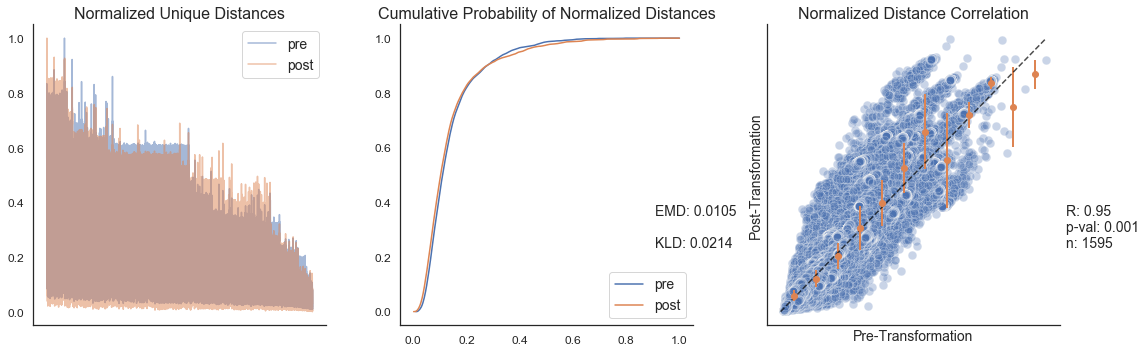

Knn Preservation: 98.1777

CPU times: user 1min 28s, sys: 14.4 s, total: 1min 43s
Wall time: 1min 43s


In [133]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0_DCA.knn_graph(k))))

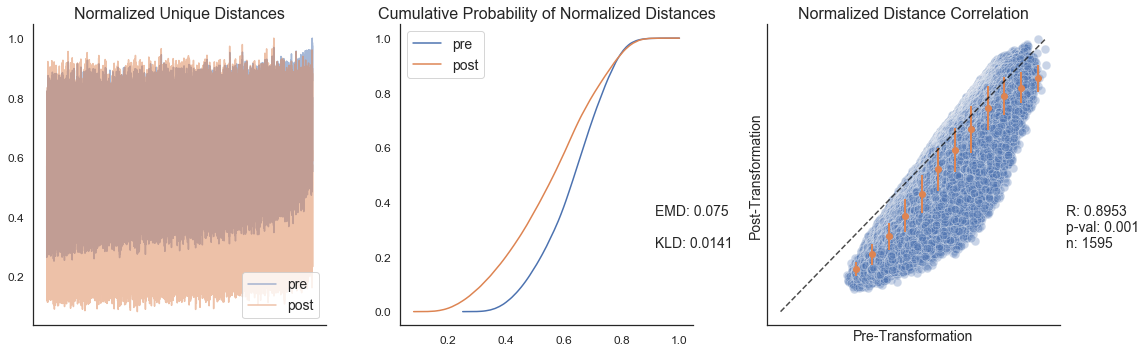

Knn Preservation: 98.2993

CPU times: user 1min 27s, sys: 12.4 s, total: 1min 39s
Wall time: 1min 40s


In [134]:
%%time
# look at 33-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA33.knn_graph(k))))

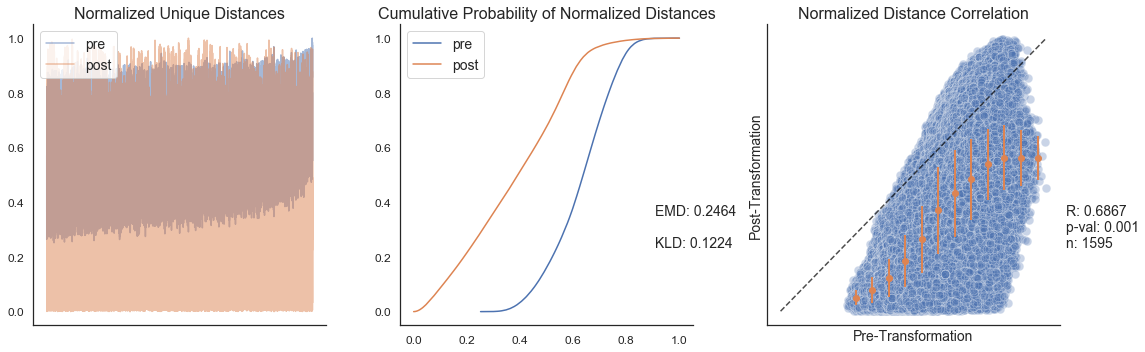

Knn Preservation: 97.5225

CPU times: user 1min 25s, sys: 12.5 s, total: 1min 37s
Wall time: 1min 37s


In [135]:
%%time
# look at ZIFA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_ZIFA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_ZIFA.knn_graph(k))))

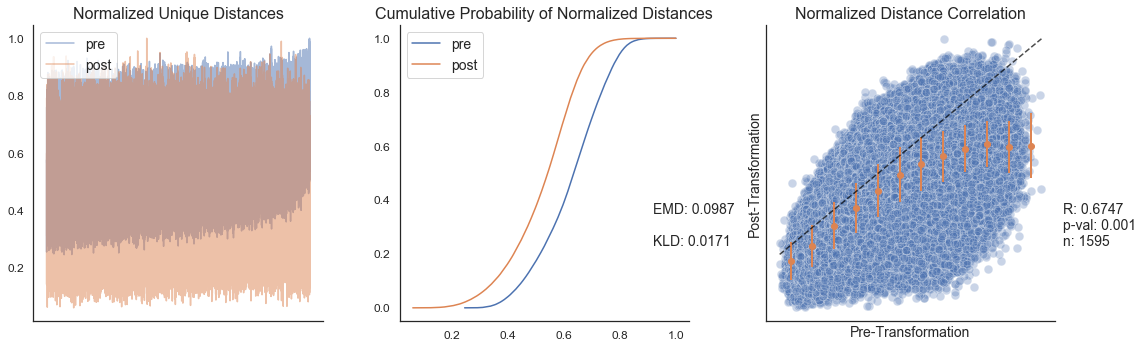

Knn Preservation: 97.4698

CPU times: user 1min 28s, sys: 11.5 s, total: 1min 40s
Wall time: 1min 39s


In [214]:
%%time
# look at scVI vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_scVI_results.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_scVI_results.knn_graph(k))))